# House price estimation with multiple inputs part 1

## Table of contents

+ Understanding the data
+ Building the model.
+ Training process.
+ Performance

## Understanding the data.

The data set I'll use for this project can be found in the next [link](https://github.com/emanhamed/Houses-dataset), this data set contains both visual and textual information for house prices estimation. Each house in the data set is represented by four images for bedroom, bathroom, kitchen and frontal image of the house. 

The data set also contains a text file with textual metadata, each row represents the number of houses in order. The numbers represent the number of bedrooms, number of bathrooms, area of the house, zip code and the price.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def read_textual_data(path, names):
    return pd.read_csv(path,header = None,sep = " ", names = names)

df = read_textual_data("../Houses-dataset/Houses-Dataset/HousesInfo.txt",
                       ["bedrooms","bathrooms","area","zipcode","price"])
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


The data set is formed of five variables, the target value is the house's price and the rest of the variables are features that I will use to predict the target value. In the data set we see one categorical variable which is the zip code. The rest of the features are numerical. Let's see the distribution of the zip code variable.

In [3]:
df.describe()

,bedrooms,bathrooms,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


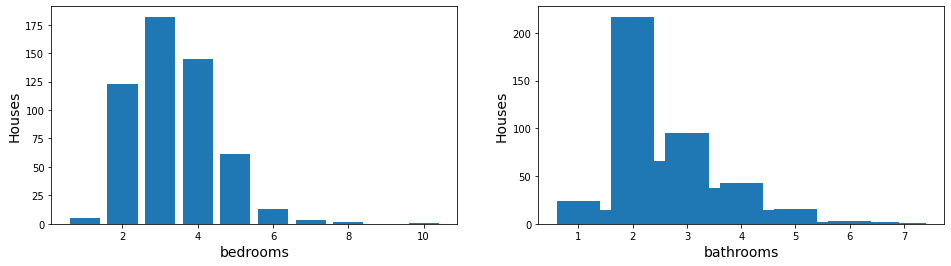

In [4]:
# using the variable axs for multiple Axes
labels = ["bedrooms","bathrooms"]
fig, axs = plt.subplots(1,2 ,figsize = (16,4))
for n,label in enumerate(labels):
    x = df[label].value_counts().index
    height = df[label].value_counts().values
    axs[n].bar(x = x, height = height,)
    axs[n].set_xlabel(label, fontsize=14)
    axs[n].set_ylabel("Houses", fontsize = 14)

Text(0, 0.5, 'Houses')

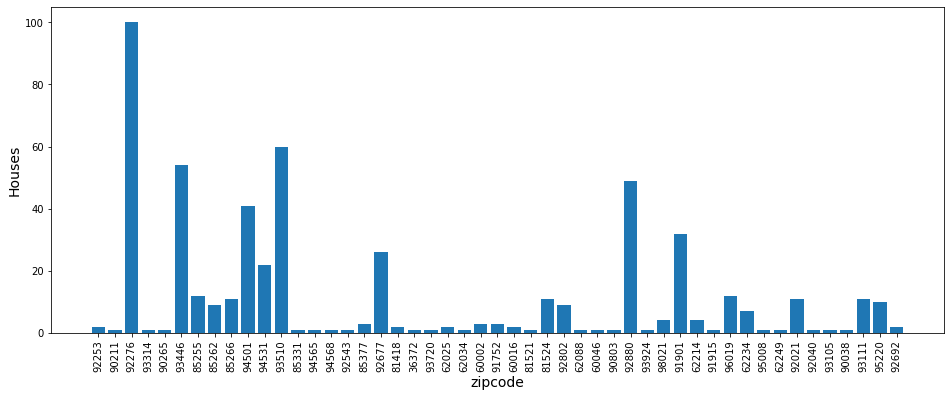

In [5]:
plt.figure(figsize=(16,6))
x = df["zipcode"].value_counts(sort=False).index
height = df["zipcode"].value_counts(sort = False).values
plt.bar(range(len(x)), height = height)
plt.xticks(range(len(x)),x);
plt.xticks(rotation=90);
plt.xlabel("zipcode", fontsize = 14)
plt.ylabel("Houses", fontsize = 14)

House distribution by zip code is highly unbalanced, so we need to pay special attention about how to feed any model with this feature since we have sometimes one or two houses by zip code. I will remove all the zip code rows having less than 25 houses. Now let's see what the distribution looks like with the changes in the zip code column.

In [6]:
zipcode_rm = df["zipcode"].value_counts()
for idx, val in zip(df["zipcode"].value_counts().keys().tolist(), df["zipcode"].value_counts().values.tolist()):
    if val <= 13:
        df.drop(df[df["zipcode"]==idx].index, inplace = True)

Text(0, 0.5, 'Houses')

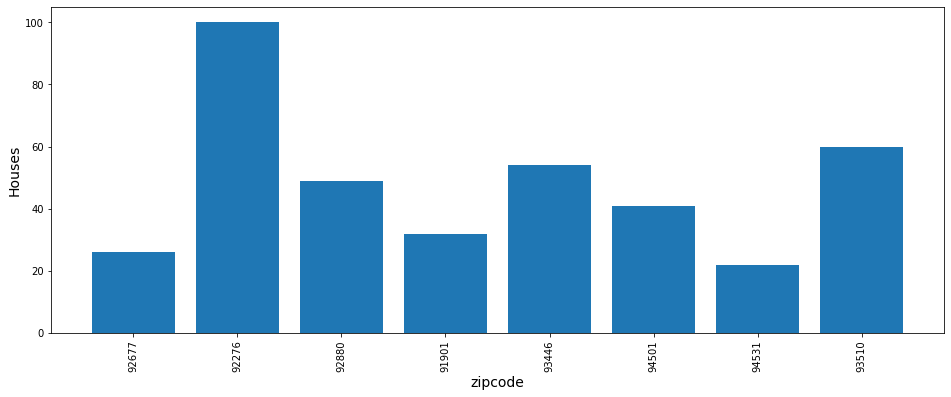

In [7]:
plt.figure(figsize=(16,6))
x = df["zipcode"].value_counts(sort=False).index
height = df["zipcode"].value_counts(sort = False).values
plt.bar(range(len(x)), height = height)
plt.xticks(range(len(x)),x);
plt.xticks(rotation=90);
plt.xlabel("zipcode", fontsize = 14)
plt.ylabel("Houses", fontsize = 14)

Now we still have some problems with the class balance, but it is less than before. The next step is to convert all the categorical data in indicator variables, I'll do this using the get_dummies() method from pandas.

In [8]:
pd.get_dummies(df.zipcode, prefix = "z").head()

,z_91901,z_92276,z_92677,z_92880,z_93446,z_93510,z_94501,z_94531
30,0,0,0,0,1,0,0,0
32,0,0,0,0,1,0,0,0
39,0,0,0,0,1,0,0,0
80,1,0,0,0,0,0,0,0
81,1,0,0,0,0,0,0,0


In [9]:
def processing_data(df, test_size):
    # categorical variable
    df_zipcode = pd.get_dummies(df.zipcode, prefix = "z")

    df_num = df[["bedrooms","bathrooms","area","price"]]
    
    #Mixing the data
    processed_data = pd.concat([df_zipcode, df_num] , axis = 1)
    
    #splitting the data
    train, test = train_test_split(processed_data, test_size = test_size, random_state = 43)
    
    #training data
    x_train = train.drop(["price"], axis = 1)
    y_train = train["price"]
    
    #testing data
    x_test = test.drop(["price"], axis = 1)
    y_test = test["price"]
    
    #min max scaler
    data_scaler = MinMaxScaler()
    
    #scaling the train data
    x_train_scaled = data_scaler.fit_transform(x_train)
    y_train_scaled = y_train/np.max(y_train)
    
    #scaling the test data
    x_test_scaled = data_scaler.transform(x_test)    
    y_test_scaled = y_test/np.max(y_train)
        
    return {
        "x_train":x_train,
        "y_train":y_train,
        "x_test":x_test,
        "y_test":y_test,
        "x_train_scaled":x_train_scaled,
        "y_train_scaled":y_train_scaled,
        "x_test_scaled":x_test_scaled,
        "y_test_scaled":y_test_scaled,
        "data_scaler":data_scaler,
    }

### Splitting the data


In [10]:
processed_data = processing_data(df, 0.3)

## Building the model

In this case we are dealing with a regression problem, there are many methods to deal with this kind of problem, but for this time I will use tensorflow and keras to build a regression model. Keras offers the opportunity to create neural network architectures easily and faster. The functional API allows more flexibility to build our models.

In [11]:
input_layer = Input(shape=(processed_data["x_train_scaled"].shape[1]))

# dense layers
first_dense = Dense(16, activation= "relu")(input_layer)
second_dense = Dense(8, activation = "relu")(first_dense)

#last layer (regression output)
last_layer = Dense(1, activation ="linear")(second_dense)

model = Model(inputs = input_layer, outputs = last_layer)

In the input layer I am defining the shape of the training data set,  the first dense and second dense layers which have 16 and 8 neurons respectively using the "relu" activation function. The last layer since will be the output layer needs only one output and should use the "linear" activation function since it is a regression problem. Finally, I built the model defining the inputs and outputs model. The architecture is shown below.

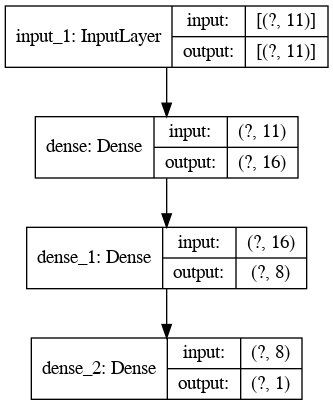

In [12]:
plot_model(model, show_layer_names=True, show_shapes=True)

### Training the model

To train the model I need to use the compile method to define the loss function and the metric to be used.

In [13]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)#tf.keras.optimizers.Adam(lr=0.001)

model.compile(optimizer= optimizer, loss="mae")

history = model.fit(
    x = processed_data["x_train_scaled"],
    y = processed_data["y_train_scaled"],
    epochs = 200,
    validation_data = (processed_data["x_test_scaled"], processed_data["y_test_scaled"]),
    batch_size = 16 
)

Epoch 1/200
17/17 [==============================] - 0s 9ms/step - loss: 0.1403 - val_loss: 0.1126
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0922 - val_loss: 0.0703
Epoch 3/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0417
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0325
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.0268
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0243
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0230
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0224
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0211
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0205
Epoch 11/

17/17 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0198
Epoch 84/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 85/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0202
Epoch 86/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0167 - val_loss: 0.0200
Epoch 87/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0200
Epoch 88/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 89/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0199
Epoch 90/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0207
Epoch 91/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0204
Epoch 92/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0202
Epoch 93/200


17/17 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0202
Epoch 165/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0210
Epoch 166/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0203
Epoch 167/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0200
Epoch 168/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0211
Epoch 169/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0205
Epoch 170/200
17/17 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0203
Epoch 171/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0204
Epoch 172/200
17/17 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0203
Epoch 173/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0203
Epoc

Now let's look at the training process history, we can see that both the loss metric and the root mean squared error are high at the beginning and decrease gradually through the epochs, we can notice how the validation metric is always higher than the metric obtained with the training data.

In [14]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

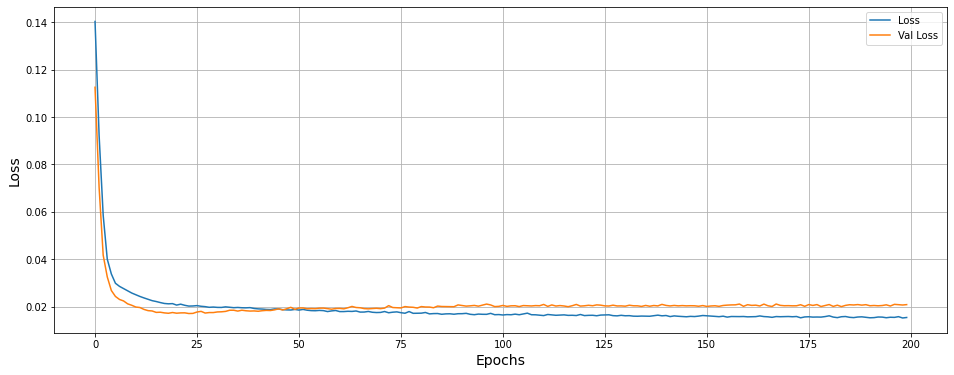

In [15]:
plt.figure(figsize=(16,6))
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid()
plt.legend(loc = "best")

In [16]:
predictions = model.predict(processed_data["x_test_scaled"]).flatten()

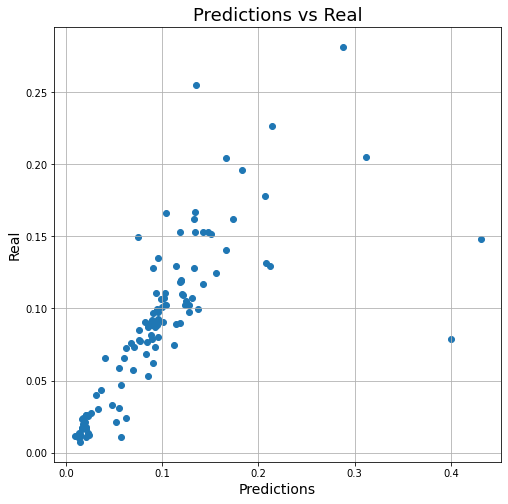

In [17]:
plt.figure(figsize = (8,8))
plt.scatter(predictions, processed_data["y_test_scaled"])
plt.title("Predictions vs Real", fontsize = 18)
plt.xlabel("Predictions", fontsize = 14)
plt.ylabel("Real", fontsize = 14)
plt.grid()


In [18]:
#error
error = predictions-processed_data["y_test_scaled"]

#mean absolute error 
mae = np.round(np.mean(np.abs(error)),2)

#root mean squared error
rmse = np.round(np.sqrt(np.mean(np.square(error))),2)

In [19]:
print(f"MAE: {mae} RMSE: {rmse}")

MAE: 0.02 RMSE: 0.05


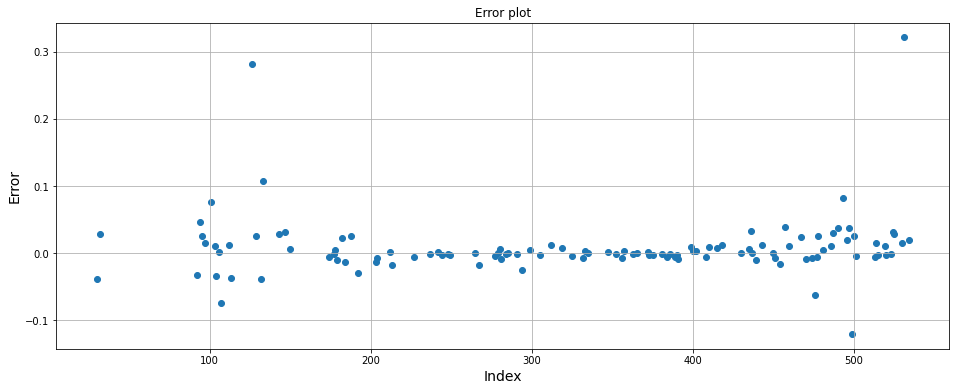

In [20]:
#error plot
plt.figure(figsize = (16,6))
plt.scatter(error.index, error.values)
plt.ylabel("Error", fontsize = 14)
plt.xlabel("Index", fontsize = 14)
plt.title("Error plot")
plt.grid()

In [21]:
processed_data["y_test"].loc[430]

699900

In [22]:
predictions[0]*max(processed_data["y_train"])

698436.7827773094